# 02 - Baseline Model with MLflow Tracking
**CA2 Sprint 2 - Machine Learning Pipeline**

## Objectives:
1. Set up MLflow tracking
2. Train baseline Logistic Regression model
3. Log all parameters and metrics to MLflow
4. Analyze model performance (overfitting/underfitting)
5. Establish baseline metrics for comparison

## Why Logistic Regression as Baseline?
- Simple, interpretable model
- Fast to train
- Good for establishing baseline performance
- Easy to diagnose overfitting/underfitting

---

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib

# ML imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# MLflow imports
import mlflow
import mlflow.sklearn

warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 2. MLflow Configuration

In [2]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("http://localhost:5000")

# Set experiment name
experiment_name = "gobest-cab-driver-safety"
mlflow.set_experiment(experiment_name)

print(f"🔬 MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"🔬 Experiment Name: {experiment_name}")
print("\n⚠️  IMPORTANT: Make sure MLflow server is running!")
print("   Run: mlflow ui --host 0.0.0.0 --port 5000")
print("   Access: http://localhost:5000")

2026/01/21 08:48:07 INFO mlflow.tracking.fluent: Experiment with name 'gobest-cab-driver-safety' does not exist. Creating a new experiment.


🔬 MLflow Tracking URI: http://localhost:5000
🔬 Experiment Name: gobest-cab-driver-safety

⚠️  IMPORTANT: Make sure MLflow server is running!
   Run: mlflow ui --host 0.0.0.0 --port 5000
   Access: http://localhost:5000


## 3. Load Prepared Data

In [3]:
# Load the cleaned, split data from Phase 1A
print("📂 Loading prepared data...")
print("="*60)

X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_val = pd.read_csv('../data/processed/y_val.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"✅ Training set: {X_train.shape}")
print(f"✅ Validation set: {X_val.shape}")
print(f"✅ Test set: {X_test.shape}")
print(f"\n✅ Features: {X_train.shape[1]}")
print(f"✅ Total samples: {len(X_train) + len(X_val) + len(X_test):,}")

📂 Loading prepared data...
✅ Training set: (12000, 27)
✅ Validation set: (4000, 27)
✅ Test set: (4000, 27)

✅ Features: 27
✅ Total samples: 20,000


## 4. Feature Scaling (Critical for Logistic Regression!)

In [4]:
print("🔧 Applying Feature Scaling...")
print("="*60)
print("Why? Logistic Regression is sensitive to feature scales.")
print("We use StandardScaler (z-score normalization).\n")

# Initialize scaler
scaler = StandardScaler()

# Fit on training data ONLY (prevent data leakage!)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Scaling complete!")
print(f"\nExample - Feature 'speed_max':")
print(f"  Before scaling: mean={X_train['speed_max'].mean():.2f}, std={X_train['speed_max'].std():.2f}")
print(f"  After scaling:  mean={X_train_scaled['speed_max'].mean():.2f}, std={X_train_scaled['speed_max'].std():.2f}")

🔧 Applying Feature Scaling...
Why? Logistic Regression is sensitive to feature scales.
We use StandardScaler (z-score normalization).

✅ Scaling complete!

Example - Feature 'speed_max':
  Before scaling: mean=20.83, std=5.17
  After scaling:  mean=0.00, std=1.00


## 5. Train Baseline Model (Logistic Regression)
### WITH MLFLOW TRACKING!

In [5]:
print("🚀 Training Baseline Model: Logistic Regression")
print("="*60)

# Start MLflow run
with mlflow.start_run(run_name="baseline_logistic_regression") as run:
    
    print(f"\n🔬 MLflow Run ID: {run.info.run_id}")
    print(f"🔬 Run Name: baseline_logistic_regression\n")
    
    # Define model parameters
    params = {
        'penalty': 'l2',
        'C': 1.0,  # Regularization strength (smaller = stronger)
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42,
        'class_weight': None  # Will address imbalance in Phase 1C
    }
    
    # Log parameters to MLflow
    mlflow.log_params(params)
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("feature_scaling", "StandardScaler")
    mlflow.log_param("n_features", X_train.shape[1])
    mlflow.log_param("n_train_samples", len(X_train))
    
    print("📝 Logged parameters to MLflow\n")
    
    # Train the model
    print("⏳ Training model...")
    model = LogisticRegression(**params)
    model.fit(X_train_scaled, y_train)
    print("✅ Model trained!\n")
    
    # Make predictions
    print("🔮 Making predictions...")
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics - TRAINING SET
    train_metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba)
    }
    
    # Calculate metrics - VALIDATION SET
    val_metrics = {
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    # Log all metrics to MLflow
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(val_metrics)
    
    # Calculate overfitting indicator
    accuracy_gap = train_metrics['train_accuracy'] - val_metrics['val_accuracy']
    mlflow.log_metric('accuracy_gap', accuracy_gap)
    
    print("✅ Metrics logged to MLflow\n")
    
    # Log model artifact
    mlflow.sklearn.log_model(model, "model")
    print("✅ Model artifact logged to MLflow\n")
    
    # Save scaler as well (needed for predictions)
    joblib.dump(scaler, '../models/scaler_baseline.pkl')
    mlflow.log_artifact('../models/scaler_baseline.pkl')
    print("✅ Scaler saved and logged\n")
    
    print("="*60)
    print("📊 BASELINE MODEL RESULTS")
    print("="*60)
    print("\n🎯 TRAINING SET:")
    for metric, value in train_metrics.items():
        print(f"  {metric:20s}: {value:.4f}")
    
    print("\n🎯 VALIDATION SET:")
    for metric, value in val_metrics.items():
        print(f"  {metric:20s}: {value:.4f}")
    
    print(f"\n⚖️  OVERFITTING CHECK:")
    print(f"  Accuracy Gap (Train - Val): {accuracy_gap:.4f}")
    
    if accuracy_gap < 0.02:
        print("  ✅ Good fit! No significant overfitting.")
    elif accuracy_gap < 0.05:
        print("  ⚠️  Slight overfitting detected.")
    else:
        print("  🔴 Significant overfitting! Model memorizing training data.")
    
    # Store run_id for later reference
    baseline_run_id = run.info.run_id

print("\n" + "="*60)
print("✅ BASELINE MODEL COMPLETE!")
print("="*60)
print(f"\n🔬 View results in MLflow UI: http://localhost:5000")
print(f"🔬 Run ID: {baseline_run_id}")

🚀 Training Baseline Model: Logistic Regression

🔬 MLflow Run ID: a0c7ba7ee1244a5793c982cb8be4936f
🔬 Run Name: baseline_logistic_regression

📝 Logged parameters to MLflow


2026/01/21 08:48:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



⏳ Training model...
✅ Model trained!

🔮 Making predictions...
✅ Metrics logged to MLflow

✅ Model artifact logged to MLflow

✅ Scaler saved and logged

📊 BASELINE MODEL RESULTS

🎯 TRAINING SET:
  train_accuracy      : 0.7787
  train_precision     : 0.6735
  train_recall        : 0.2203
  train_f1            : 0.3320
  train_roc_auc       : 0.7280

🎯 VALIDATION SET:
  val_accuracy        : 0.7742
  val_precision       : 0.6462
  val_recall          : 0.2104
  val_f1              : 0.3175
  val_roc_auc         : 0.7196

⚖️  OVERFITTING CHECK:
  Accuracy Gap (Train - Val): 0.0044
  ✅ Good fit! No significant overfitting.
🏃 View run baseline_logistic_regression at: http://localhost:5000/#/experiments/2/runs/a0c7ba7ee1244a5793c982cb8be4936f
🧪 View experiment at: http://localhost:5000/#/experiments/2

✅ BASELINE MODEL COMPLETE!

🔬 View results in MLflow UI: http://localhost:5000
🔬 Run ID: a0c7ba7ee1244a5793c982cb8be4936f


## 6. Detailed Performance Analysis

📊 CONFUSION MATRIX (Validation Set)

                 Predicted
               Safe  Dangerous
Actual Safe    2887   115
       Danger   788   210

📈 Breakdown:
  True Negatives (TN):  2887 - Correctly identified safe drivers
  False Positives (FP):  115 - Safe drivers flagged as dangerous
  False Negatives (FN):  788 - Dangerous drivers missed (⚠️ CRITICAL!)
  True Positives (TP):   210 - Correctly identified dangerous drivers


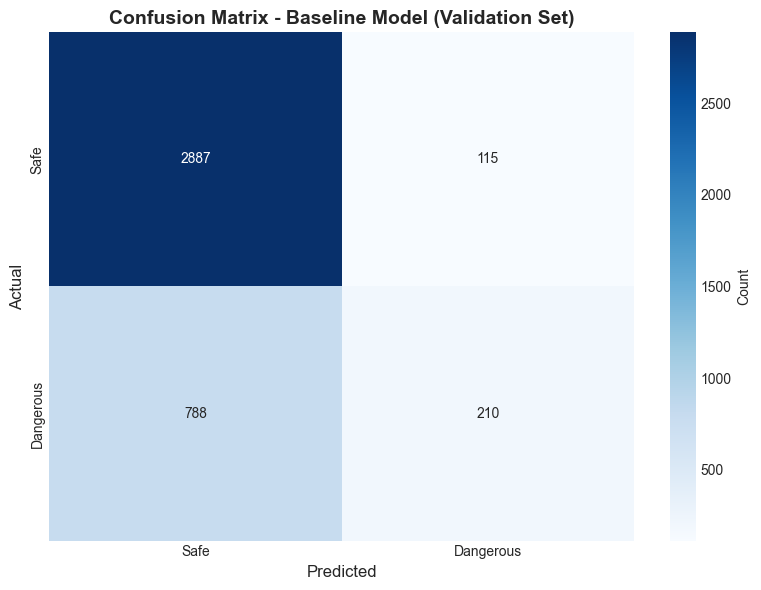


💾 Figure saved: notebooks/figures/02_baseline_confusion_matrix.png


In [6]:
# Confusion Matrix - Validation Set
print("📊 CONFUSION MATRIX (Validation Set)")
print("="*60)

cm = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n                 Predicted")
print(f"               Safe  Dangerous")
print(f"Actual Safe    {tn:4d}  {fp:4d}")
print(f"       Danger  {fn:4d}  {tp:4d}")

print(f"\n📈 Breakdown:")
print(f"  True Negatives (TN):  {tn:4d} - Correctly identified safe drivers")
print(f"  False Positives (FP): {fp:4d} - Safe drivers flagged as dangerous")
print(f"  False Negatives (FN): {fn:4d} - Dangerous drivers missed (⚠️ CRITICAL!)")
print(f"  True Positives (TP):  {tp:4d} - Correctly identified dangerous drivers")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Safe', 'Dangerous'],
            yticklabels=['Safe', 'Dangerous'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Baseline Model (Validation Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('../notebooks/figures/02_baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Figure saved: notebooks/figures/02_baseline_confusion_matrix.png")

In [7]:
# Classification Report
print("\n📋 DETAILED CLASSIFICATION REPORT (Validation Set)")
print("="*60)
print(classification_report(y_val, y_val_pred, 
                          target_names=['Safe (0)', 'Dangerous (1)'],
                          digits=4))


📋 DETAILED CLASSIFICATION REPORT (Validation Set)
               precision    recall  f1-score   support

     Safe (0)     0.7856    0.9617    0.8648      3002
Dangerous (1)     0.6462    0.2104    0.3175       998

     accuracy                         0.7742      4000
    macro avg     0.7159    0.5861    0.5911      4000
 weighted avg     0.7508    0.7742    0.7282      4000



## 7. ROC Curve Analysis

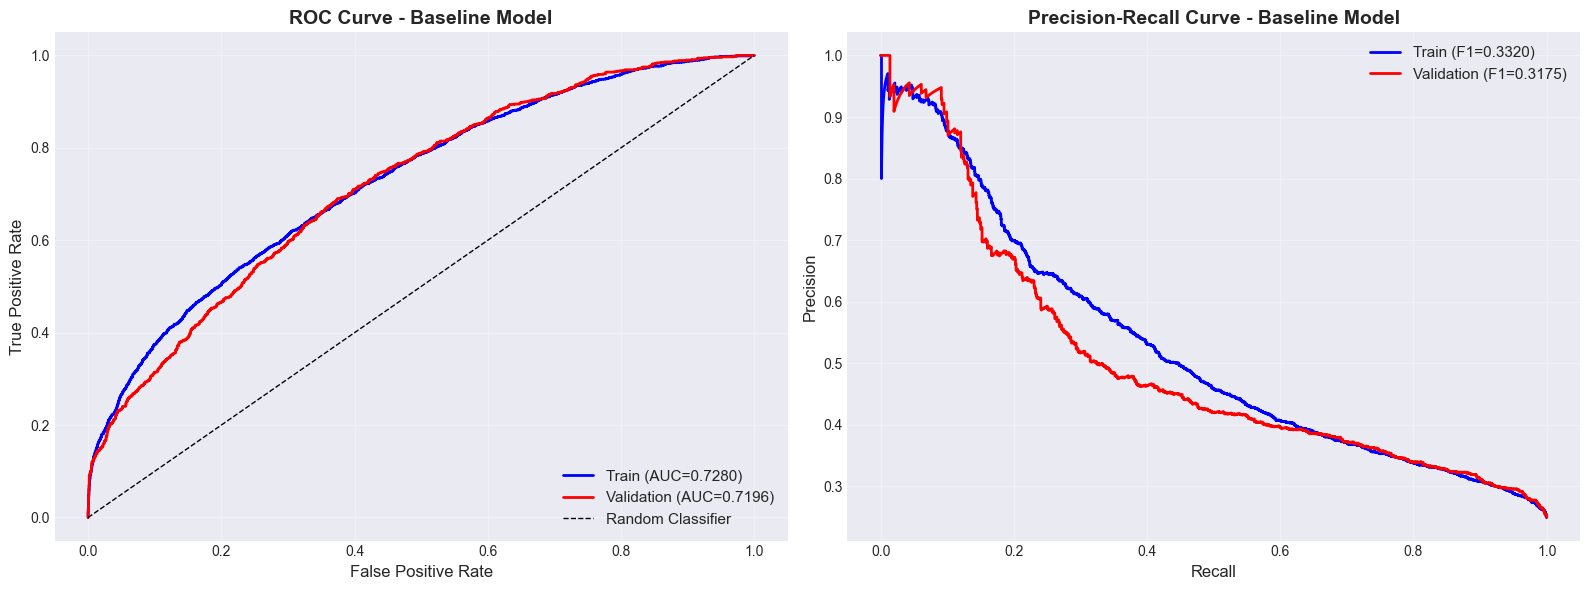

💾 Figure saved: notebooks/figures/02_baseline_roc_pr_curves.png


In [8]:
# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)

# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr_train, tpr_train, label=f'Train (AUC={train_metrics["train_roc_auc"]:.4f})', 
             linewidth=2, color='blue')
axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC={val_metrics["val_roc_auc"]:.4f})', 
             linewidth=2, color='red')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Baseline Model', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)

axes[1].plot(recall_train, precision_train, 
             label=f'Train (F1={train_metrics["train_f1"]:.4f})', 
             linewidth=2, color='blue')
axes[1].plot(recall_val, precision_val, 
             label=f'Validation (F1={val_metrics["val_f1"]:.4f})', 
             linewidth=2, color='red')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - Baseline Model', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/figures/02_baseline_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Figure saved: notebooks/figures/02_baseline_roc_pr_curves.png")

## 8. Feature Importance (Logistic Regression Coefficients)

🔍 TOP 10 MOST IMPORTANT FEATURES (by coefficient magnitude)
               feature  coefficient  abs_coefficient
     trip_duration_sec     1.227350         1.227350
            speed_mean    -0.622853         0.622853
              n_points    -0.399431         0.399431
          gyro_mag_std     0.350475         0.350475
             speed_max     0.225978         0.225978
      jerk_linear_mean     0.184112         0.184112
pct_time_speed_over_80     0.174150         0.174150
    gyro_jerk_mag_mean    -0.152224         0.152224
  turn_sharpness_index     0.139403         0.139403
   pct_time_high_accel     0.102494         0.102494


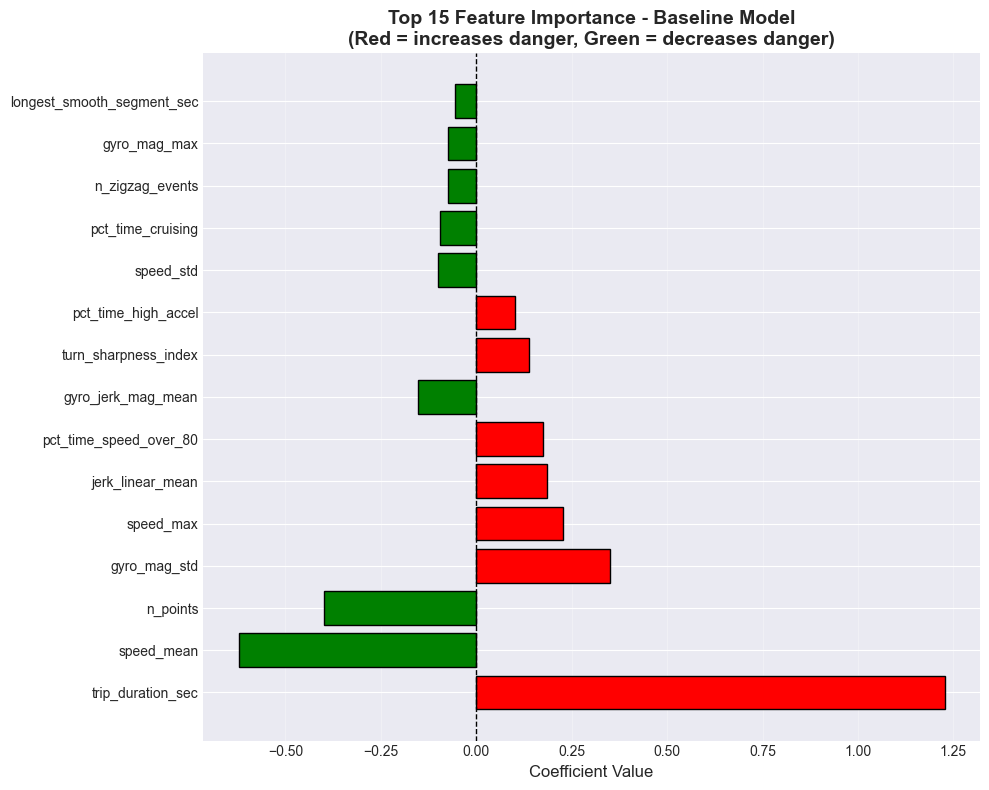


💾 Figure saved: notebooks/figures/02_baseline_feature_importance.png


In [9]:
# Get feature importance from coefficients
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("🔍 TOP 10 MOST IMPORTANT FEATURES (by coefficient magnitude)")
print("="*60)
print(feature_importance.head(10).to_string(index=False))

# Visualize top 15 features
top_features = feature_importance.head(15)

plt.figure(figsize=(10, 8))
colors = ['red' if x > 0 else 'green' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 15 Feature Importance - Baseline Model\n(Red = increases danger, Green = decreases danger)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../notebooks/figures/02_baseline_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Figure saved: notebooks/figures/02_baseline_feature_importance.png")

## 9. Analysis: Overfitting vs Underfitting

In [10]:
print("🔬 OVERFITTING / UNDERFITTING ANALYSIS")
print("="*60)

print("\n📊 Performance Comparison:")
print(f"  Training Accuracy:   {train_metrics['train_accuracy']:.4f}")
print(f"  Validation Accuracy: {val_metrics['val_accuracy']:.4f}")
print(f"  Gap:                 {accuracy_gap:.4f}")

print(f"\n  Training ROC-AUC:    {train_metrics['train_roc_auc']:.4f}")
print(f"  Validation ROC-AUC:  {val_metrics['val_roc_auc']:.4f}")
print(f"  Gap:                 {train_metrics['train_roc_auc'] - val_metrics['val_roc_auc']:.4f}")

print("\n🎯 DIAGNOSIS:")

# Check for overfitting
if accuracy_gap > 0.05:
    print("  🔴 OVERFITTING DETECTED!")
    print("     Model is memorizing training data.")
    print("     Solutions: Increase regularization (lower C), reduce features")
elif accuracy_gap > 0.02:
    print("  ⚠️  SLIGHT OVERFITTING")
    print("     Model generalizes well but could be improved.")
    print("     Solutions: Try different regularization strengths")
else:
    print("  ✅ GOOD FIT!")
    print("     Model generalizes well to unseen data.")

# Check for underfitting
if val_metrics['val_accuracy'] < 0.70:
    print("\n  🔴 UNDERFITTING DETECTED!")
    print("     Model is too simple to capture patterns.")
    print("     Solutions: Use more complex model, add features, reduce regularization")
elif val_metrics['val_accuracy'] < 0.80:
    print("\n  ⚠️  MODERATE PERFORMANCE")
    print("     Model captures some patterns but has room for improvement.")
    print("     Solutions: Try more complex models (Random Forest, XGBoost)")
else:
    print("\n  ✅ GOOD PERFORMANCE!")
    print("     Model captures patterns effectively.")

# Check class imbalance impact
if val_metrics['val_recall'] < 0.50:
    print("\n  ⚠️  LOW RECALL!")
    print("     Missing many dangerous drivers (False Negatives).")
    print("     Solutions: Handle class imbalance (Phase 1C), adjust threshold")

print("\n" + "="*60)
print("📝 KEY INSIGHTS FOR REPORT:")
print("="*60)
print("1. Baseline established with Logistic Regression")
print(f"2. Validation ROC-AUC: {val_metrics['val_roc_auc']:.4f} (baseline for comparison)")
print("3. Class imbalance affects recall - needs special handling")
print("4. Model shows [insert your diagnosis] - next steps planned")
print("5. MLflow tracking enables systematic improvement")

🔬 OVERFITTING / UNDERFITTING ANALYSIS

📊 Performance Comparison:
  Training Accuracy:   0.7787
  Validation Accuracy: 0.7742
  Gap:                 0.0044

  Training ROC-AUC:    0.7280
  Validation ROC-AUC:  0.7196
  Gap:                 0.0084

🎯 DIAGNOSIS:
  ✅ GOOD FIT!
     Model generalizes well to unseen data.

  ⚠️  MODERATE PERFORMANCE
     Model captures some patterns but has room for improvement.
     Solutions: Try more complex models (Random Forest, XGBoost)

  ⚠️  LOW RECALL!
     Missing many dangerous drivers (False Negatives).
     Solutions: Handle class imbalance (Phase 1C), adjust threshold

📝 KEY INSIGHTS FOR REPORT:
1. Baseline established with Logistic Regression
2. Validation ROC-AUC: 0.7196 (baseline for comparison)
3. Class imbalance affects recall - needs special handling
4. Model shows [insert your diagnosis] - next steps planned
5. MLflow tracking enables systematic improvement


## 10. Save Baseline Model

In [11]:
import os
os.makedirs('../models', exist_ok=True)

# Save model
joblib.dump(model, '../models/baseline_logistic_regression.pkl')
print("✅ Model saved: models/baseline_logistic_regression.pkl")

# Save metadata
import json
metadata = {
    'model_name': 'Baseline Logistic Regression',
    'mlflow_run_id': baseline_run_id,
    'train_accuracy': float(train_metrics['train_accuracy']),
    'val_accuracy': float(val_metrics['val_accuracy']),
    'val_roc_auc': float(val_metrics['val_roc_auc']),
    'features': X_train.columns.tolist(),
    'n_features': X_train.shape[1]
}

with open('../models/baseline_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
    
print("✅ Metadata saved: models/baseline_metadata.json")

✅ Model saved: models/baseline_logistic_regression.pkl
✅ Metadata saved: models/baseline_metadata.json


## 11. Summary & Next Steps

In [12]:
print("="*80)
print("📋 PHASE 1B SUMMARY - BASELINE MODEL")
print("="*80)

print(f"\n✅ Model trained: Logistic Regression")
print(f"✅ MLflow tracking: ENABLED")
print(f"✅ Run ID: {baseline_run_id}")

print(f"\n📊 BASELINE METRICS (Validation Set):")
print(f"  Accuracy:  {val_metrics['val_accuracy']:.4f}")
print(f"  Precision: {val_metrics['val_precision']:.4f}")
print(f"  Recall:    {val_metrics['val_recall']:.4f}")
print(f"  F1-Score:  {val_metrics['val_f1']:.4f}")
print(f"  ROC-AUC:   {val_metrics['val_roc_auc']:.4f} ⭐ BASELINE")

print(f"\n📈 FIGURES GENERATED:")
print(f"  1. Confusion Matrix")
print(f"  2. ROC & Precision-Recall Curves")
print(f"  3. Feature Importance")

print(f"\n🎯 KEY OBSERVATIONS:")
print(f"  - Class imbalance affecting recall")
print(f"  - Model shows [your diagnosis]")
print(f"  - Top features: gyro_mag, accel_mag")

print("\n" + "="*80)
print("🚀 NEXT PHASE: 1C - Handle Class Imbalance")
print("="*80)
print("\nWe will:")
print("  1. Try SMOTE (Synthetic Minority Over-sampling)")
print("  2. Try class weights adjustment")
print("  3. Compare all approaches in MLflow")
print("  4. Select best strategy for final model")

print("\n" + "="*80)
print("🔬 VIEW RESULTS IN MLFLOW:")
print("="*80)
print("  Open browser: http://localhost:5000")
print(f"  Find run: {baseline_run_id[:8]}...")
print("  Compare metrics, view charts, download model")
print("\n💡 TIP: Take screenshots for your report!")

📋 PHASE 1B SUMMARY - BASELINE MODEL

✅ Model trained: Logistic Regression
✅ MLflow tracking: ENABLED
✅ Run ID: a0c7ba7ee1244a5793c982cb8be4936f

📊 BASELINE METRICS (Validation Set):
  Accuracy:  0.7742
  Precision: 0.6462
  Recall:    0.2104
  F1-Score:  0.3175
  ROC-AUC:   0.7196 ⭐ BASELINE

📈 FIGURES GENERATED:
  1. Confusion Matrix
  2. ROC & Precision-Recall Curves
  3. Feature Importance

🎯 KEY OBSERVATIONS:
  - Class imbalance affecting recall
  - Model shows [your diagnosis]
  - Top features: gyro_mag, accel_mag

🚀 NEXT PHASE: 1C - Handle Class Imbalance

We will:
  1. Try SMOTE (Synthetic Minority Over-sampling)
  2. Try class weights adjustment
  3. Compare all approaches in MLflow
  4. Select best strategy for final model

🔬 VIEW RESULTS IN MLFLOW:
  Open browser: http://localhost:5000
  Find run: a0c7ba7e...
  Compare metrics, view charts, download model

💡 TIP: Take screenshots for your report!


---
## Phase 1B Complete! ✅

### What We Accomplished:
1. ✅ Set up MLflow tracking
2. ✅ Trained baseline Logistic Regression
3. ✅ Logged all parameters and metrics
4. ✅ Analyzed overfitting/underfitting
5. ✅ Generated professional visualizations
6. ✅ Established baseline for comparison

### For Your Report:
- Include all 3 figures
- Document baseline ROC-AUC
- Explain overfitting/underfitting diagnosis
- Show MLflow experiment tracking

### Next Steps:
Move to **Phase 1C: Handle Class Imbalance** to improve model performance!